<a href="https://colab.research.google.com/github/MichaelReh/testingSGppNotebooks/blob/master/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the 'Open in Colab' button to execute this notebook in Google Colab. No local installation of $SG^{++}$ is required.

The following illustrates how you can install the latest version of SG++ in a Colab instance. However, for this tutorial we offer a precompiled version, so you can ignore this code block

In [0]:
## -*- coding: utf-8 -*-
#! apt-get install scons swig # build tools for sgpp
#! git clone https://github.com/SGpp/SGpp.git
#! cd SGpp 
#
## install sgpp -- start early, takes > 30min!
#!cd SGpp  && scons -j4 SG_BASE=1 SG_COMBIGRID=1 SG_DATADRIVEN=1 SG_MISC=0 SG_OPTIMIZATION=1 SG_PDE=1 SG_QUADRATURE=1 SG_SOLVER=1 SG_JAVA=0 SG_MATLAB=0 SG_PYTHON=1 COMPILE_BOOST_TESTS=0 RUN_BOOST_TESTS=0
#
#import sys
#import os
#
#sgpp_folder = "SGpp"
#
## Make python interface available
#if not 'moduleDir' in globals():
#    moduleDir = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib")
#    pysgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/pysgpp")
#    sys.path.append(moduleDir)
#    sys.path.append(pysgpp_path)
#
#sgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/sgpp")
#
## do file fiddling necessary in colab so everything is found
#!sed -ie 's/^\(from . import extensions\)/try:\n    \1\nexcept:\n    import extensions/' $pysgpp_path/__init__.py
#!cp $sgpp_path/* /usr/lib

In [0]:
#! wget https://ipvs.informatik.uni-stuttgart.de/cloud/s/xwRLygmKQ5HzRJK/download
https://ipvs.informatik.uni-stuttgart.de/cloud/s/jpnr5FfDWiKMF6y/download
! mv download SGpp.zip
! unzip SGpp.zip

--2019-11-22 02:48:59--  https://ipvs.informatik.uni-stuttgart.de/cloud/s/xwRLygmKQ5HzRJK/download
Resolving ipvs.informatik.uni-stuttgart.de (ipvs.informatik.uni-stuttgart.de)... 129.69.216.7, 2001:7c0:2015:216::7
Connecting to ipvs.informatik.uni-stuttgart.de (ipvs.informatik.uni-stuttgart.de)|129.69.216.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1049799272 (1001M) [application/zip]
Saving to: ‘download’

download            100%[===================>]   1001M   237MB/s    in 4.4s    

2019-11-22 02:49:03 (226 MB/s) - ‘download’ saved [1049799272/1049799272]

Archive:  SGpp.zip
   creating: SGpp/
  inflating: SGpp/.gitignore         
  inflating: SGpp/INSTRUCTIONS_MAC   
   creating: SGpp/solver/
   creating: SGpp/solver/src/
  inflating: SGpp/solver/src/sgpp_solver.hpp  
   creating: SGpp/solver/src/sgpp/
   creating: SGpp/solver/src/sgpp/solver/
  inflating: SGpp/solver/src/sgpp/solver/SLESolverSP.hpp  
 extracting: SGpp/solver/src/sgpp/solver/SGSolv

In [0]:
import sys
import os
sgpp_folder = "SGpp"

# Make python interface available
if not 'moduleDir' in globals():
    moduleDir = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib")
    pysgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/pysgpp")
    sys.path.append(moduleDir)
    sys.path.append(pysgpp_path)

sgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/sgpp")
# copy shared libs to where we're looking for libraries
!cp $sgpp_path/* /usr/lib

# Optimization
This notebook demonstrates optimization with SG++.
It shows:
- how to create an objective function object
- how to interpolate with B-splines by explicitly creating the SLE
- how to calculate the optimum using gradient descent

Note: If you want to run these introductory notebooks interactively in your browser, you can use Google Colab. See [the according Wiki page](https://github.com/SGpp/SGpp/wiki/Installing-pysgpp-on-colab) for more instructions.

The example interpolates a bivariate test function like the `Interpolation.ipynb` notebook.
However, it uses B-splines here instead to obtain a smoother interpolant.  
The resulting sparse grid function is then minimized with the method of steepest descent.
For comparison, the objective function is also minimized with Nelder-Mead's method.

Import the necessary modules. The python bindings for SG++ are called "pysgpp".

In [0]:
%matplotlib notebook
%matplotlib inline
from __future__ import print_function
import pysgpp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import numpy as np

The objective function $f\colon [0, 1]^D \to \mathbb{R}$ to be minimized
has to derive from `ScalarFunction`.
In the constructor, we give the dimensionality of the domain
(in this case $d = 2$).
The eval method evaluates the objective function and returns the function
value $f(\vec{x})$ for a given point $\vec{x} \in [0, 1]^D$.

In [0]:
class ExampleFunction(pysgpp.ScalarFunction):
    """Example objective function."""
    def __init__(self):
        dim = 2
        super(ExampleFunction, self).__init__(dim)

    def eval(self, x):
        """Evaluates the function."""
        return np.sin(8.0 * x[0]) + np.sin(7.0 * x[1])

Plot the objective function.

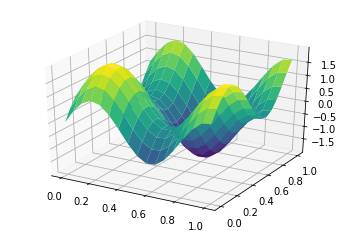

In [0]:
XX = np.linspace(0,1,17)
(X, Y) = np.meshgrid(XX, XX)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
def ff(x1, x2):
    return np.sin(8.0*x1) + np.sin(7.0*x2)
ax.plot_surface(X, Y, ff(X, Y), rstride=1, cstride=1, cmap='viridis')

OpenMP within pysgpp must be disabled for objective functions defined in Python, since it interferes with SWIG's director feature.  
Set the verbosity level to obtain more/less information on grid generation, SLE solving and optimization printed to the console.

Note: If parallel execution is needed for performance, implement the objective function directly  in C++.

In [0]:
pysgpp.omp_set_num_threads(1)

# increase verbosity of the output
pysgpp.Printer.getInstance().setVerbosity(2)

Define parameters: objective function, dimensionality,
B-spline degree, maximal number of grid points, and adaptivity.

In [0]:
# objective function
f = ExampleFunction()
# dimension of domain
d = f.getNumberOfParameters()
# B-spline degree
p = 3
# maximal number of grid points
N = 30
# gamma determines the adaptivity of grid generation
# compromise between exploration (gamma = 0) and exploitation (gamma = 1)
gamma = 0.95

Define a grid of dimension `d` with modified B-spline basis functions of degree `p`.

In [0]:
grid = pysgpp.Grid.createModBsplineGrid(d, p)


Define an iterative grid generator, which can generate the grid adaptively. Apply the grid generator with the previousy defined parameters.

In [0]:
gridGen = pysgpp.OptIterativeGridGeneratorRitterNovak(f, grid, N, gamma)
if not gridGen.generate():
    print("Grid generation failed, exiting.")
    sys.exit(1)

Hierarchize the objective function values to get hierarchical B-spline
coefficients of the B-spline sparse grid interpolant
$\tilde{f}\colon [0, 1]^d \to \mathbb{R}$.  
The hierarchization requires the interpolation SLE `hierSLE` which is automatically created depending on the `grid`, and an `sleSolver` to solve this SLE. Here the `AutoSLESolver` is used, which automatically picks a suiting solver library among the available choices.

Note: SG++ supports the libraries Eigen, Armadillo, UMFPACK and GMPP for SLE solving. Use the flags USE_EIGEN, USE_ARMADILLO, USE_UMFPACK, USE_GMMP to compile SG++ with the according library. If none of these libraries is found by SG++ a simple gaussian elimination is used.

In [0]:
functionValues = gridGen.getFunctionValues()
coeffs = pysgpp.DataVector(len(functionValues))
hierSLE = pysgpp.HierarchisationSLE(grid)
sleSolver = pysgpp.AutoSLESolver()

# solve linear system
if not sleSolver.solve(hierSLE, gridGen.getFunctionValues(), coeffs):
    print("Solving failed, exiting.")
    sys.exit(1)

Define the interpolant $\tilde{f}$ and its gradient $\nabla\tilde{f}$ for use with the gradient method (steepest descent). The `InterpolantScalarFunction` and `InterpolantScalarFunctionGradient` provide handy wrappers for this.

Note: Other optimization algorithms are available from `sgpp::optimization::optimizer`.

In [0]:
ft = pysgpp.InterpolantScalarFunction(grid, coeffs)
ftGradient = pysgpp.InterpolantScalarFunctionGradient(grid, coeffs)
gradientDescent = pysgpp.OptGradientDescent(ft, ftGradient)

The gradient method needs a starting point.
Here, we use a point of our adaptively generated sparse grid as starting point.
More specifically, we use the point with the smallest
(most promising) function value and save it in x0.

Note: MultiStart is available, to improve convergence of the optimization routines.

In [0]:
gridStorage = gridGen.getGrid().getStorage()

# index of grid point with minimal function value
x0 = pysgpp.DataVector(d)
x0Index = 0
fX0 = functionValues[0]
for i in range(1, len(functionValues)):
    if functionValues[i] < fX0:
        fX0 = functionValues[i]
        x0Index = i

x0 = gridStorage.getCoordinates(gridStorage.getPoint(x0Index));
ftX0 = ft.eval(x0)

print("x0 = {}".format(x0))
print("f(x0) = {:.6g}, ft(x0) = {:.6g}\n".format(fX0, ftX0))

x0 = [6.25000000000000000000e-01, 7.50000000000000000000e-01]
f(x0) = -1.81786, ft(x0) = -1.81786



Set the starting point, apply the gradient method and print the results.

In [0]:
gradientDescent.setStartingPoint(x0)
gradientDescent.optimize()
xOpt = gradientDescent.getOptimalPoint()
ftXOpt = gradientDescent.getOptimalValue()
fXOpt = f.eval(xOpt)

print("\nxOpt = {}".format(xOpt))
print("f(xOpt) = {:.6g}, ft(xOpt) = {:.6g}\n".format(fXOpt, ftXOpt))


xOpt = [5.89526019987554272817e-01, 6.73267822377386027100e-01]
f(xOpt) = -1.99999, ft(xOpt) = -2.00078



For comparison, apply the classical gradient-free Nelder-Mead method
directly to the objective function $f$.

In [0]:
nelderMead = pysgpp.OptNelderMead(f, 1000)
nelderMead.optimize()
xOptNM = nelderMead.getOptimalPoint()
fXOptNM = nelderMead.getOptimalValue()
ftXOptNM = ft.eval(xOptNM)

print("\nxOptNM = {}".format(xOptNM))
print("f(xOptNM) = {:.6g}, ft(xOptNM) = {:.6g}\n".format(fXOptNM, ftXOptNM))


xOptNM = [5.89048623597983933564e-01, 6.73198424791973115688e-01]
f(xOptNM) = -2, ft(xOptNM) = -2.00077



We see that both the gradient-based optimization of the smooth sparse grid
interpolant and the gradient-free optimization of the objective function
find reasonable approximations of the minimum, which lies at
$(3\pi/16, 3\pi/14) \approx (0.58904862, 0.67319843)$.